Following example shows:
- complete graph with size 5 where the optimal intervention is on last 2 nodes
- number of instances=3
- number of runs for each method=10
- number of time steps=10

To replicate the plots (**Fig. 5, S4-7**) in the paper: change the above parameters according to the paper

In [9]:
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from optint.data import synthetic_instance, gen_dag
from optint.run import run
from optint.visualize import *

### Generate synthetic instances

In [2]:
seed = 1234
np.random.seed(seed)

# generate problem instantiation
nnodes = 5
sigma_square = np.ones(nnodes)
DAG_type = 'complete'

num_instances = 3
a_size = 2

problems = []
graph = gen_dag(nnodes=nnodes, DAG_type=DAG_type)
for _ in range(num_instances):
	problem = synthetic_instance(
		nnodes=nnodes, 
		DAG_type=DAG_type,
		std=True,
		sigma_square=sigma_square, 
		a_size=a_size,
		a_target_nodes=[i+3 for i in range(a_size)], 
		prefix_DAG=graph
		)
	problems.append(problem)

there are no undirected edges
plotting...


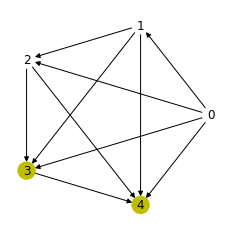

In [3]:
draw(
	problem.DAG, 
	colored_set = set(i for i in range(problem.nnodes) if problem.a_target[i]!=0), 
	affected_set=set().union(*[problem.DAG.descendants_of(i) for i in range(problem.nnodes) if problem.a_target[i]!=0]),
	)

### Run 5 methods

In [4]:
# options for testing
opts = Namespace(n=1, T=10, W=0, R=10)

In [5]:
acqs = ['greedy', 'maxv','cv', 'civ', 'civ']
measure = [None, None, None, 'unif', 'ow']
known_variance = [False, True, True, True, True]
name = ['greedy', 'maxv', 'cv', 'civ', 'civow']


MSEs = []
As = []
Probs = []
for i in range(num_instances):
	problem = problems[i]

	A = {}
	Prob = {}
	
	opts.active = False
	A['passive'], Prob['passive'] = run(problem, opts)

	opts.active = True
	for a in range(len(acqs)):
		opts.acq = acqs[a]
		opts.measure = measure[a]
		opts.known_noise = known_variance[a]
		A[name[a]], Prob[name[a]] = run(problem, opts)	

	print(f'Graph {i+1}')

	As.append(A)
	Probs.append(Prob)

100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Graph 1


100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


Graph 2


100%|██████████| 10/10 [00:01<00:00,  9.18it/s]

Graph 3


### Plot results

In [6]:
mu_MSEs = []
for i in range(num_instances):
	Prob = Probs[i]
	problem = problems[i]
	mu_mses = {k:[] for k in ['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow']}
	for r in range(opts.R):
		for k in ['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow']:
			mse = []
			for prob in Prob[k][r]:
				errs = abs(np.dot(np.eye(problem.nnodes)-np.array(prob['mean']),problem.mu_target) - problem.a_target)
				mse.append(np.linalg.norm(np.concatenate(errs))**2)
			mu_mses[k].append(mse)
	mu_MSEs.append(mu_mses)


<Figure size 432x288 with 0 Axes>

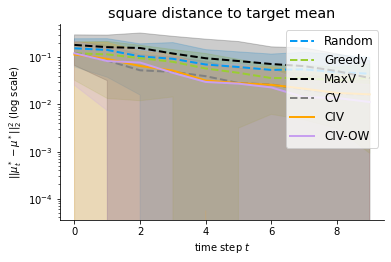

In [7]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(5.6,3.8))
plt.rcParams.update({'font.size': 12})

plt.yscale('log')

labels = ['Random', 'Greedy', 'MaxV', 'CV', 'CIV', 'CIV-OW']
colors = ['#069AF3', '#9ACD32', 'black', 'grey', 'orange', '#C79FEF']
markers = ['^', 'o', 'o', 'o', 's', 's']
linestyles = ['--','--','--', '--','-', '-']
for i, k in enumerate(['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow']):
	mean = np.array([np.array(mu_MSEs[i][k]).mean(axis=0) for i in range(num_instances)]).mean(axis=0)
	std = np.array([np.array(mu_MSEs[i][k]).std(axis=0) for i in range(num_instances)]).mean(axis=0)
	plt.plot(range(opts.T), mean, label=labels[i], linewidth=2, color=colors[i], marker=markers[i], markersize=0, linestyle=linestyles[i])
	plt.fill_between(range(opts.T), mean - std, mean + std, alpha=.2, color=colors[i])

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# plt.ylim(0.01,1)

plt.legend(loc='upper right')
plt.xlabel(r'time step $t$')
plt.ylabel(r'$||\mu_t^*-\mu^*||_2^2$ (log scale)')
plt.title(f'square distance to target mean')
plt.tight_layout()

# plt.savefig(f'figure/mse-mean_{DAG_type}-{nnodes}-{a_size}.pdf')

<Figure size 432x288 with 0 Axes>

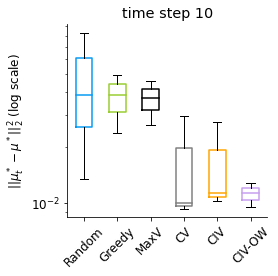

In [8]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.rcParams.update({'font.size': 12})

data = []
for k in ['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow']:
	data.append([np.array(mu_MSEs[i][k]).mean(axis=0)[-1] for i in range(num_instances)])
bplots = plt.boxplot(data, labels=['Random', 'Greedy', 'MaxV', 'CV', 'CIV', 'CIV-OW'], patch_artist=False);

# fill with colors
colors = ['#069AF3', '#9ACD32', 'black', 'grey', 'orange', '#C79FEF']

for patch, color in zip(bplots['boxes'], colors):
	# patch.set_facecolor(color)
	patch.set(color=color, linewidth=1.5)
	
for line, color in zip(bplots['medians'], colors):
	# patch.set_facecolor(color)
	line.set(color=color, linewidth=1.5)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.ylabel(r'$||\mu_t^*-\mu^*||_2^2$ (log scale)')
plt.title(f'time step {opts.T}')
plt.yscale('log')
plt.tight_layout()

# plt.savefig(f'fig/bplot_{DAG_type}-{nnodes}-{a_size}.pdf')